# Assignment 2 
## Part 1: Non-Linear Classification with SVM

In this assignment, you will implement your SVM with kernels using sklearn to classify non-linear data. Note that you must save your Notebook and submit that version.


## DATA SET AND VISUALIZATION FUNCTION
We will use the non-linear toy data called the Moon dataset. You may use the code snippet below to generate the train/test set. Feel free to change the number of samples, and noise level. Additionally, a function plot_svm() is provided to help you visualize the decision boundary, margin, and support vectors on the dataset in 2D feature space.

The provided function plot_svm() works out-the-box, and is the best way to visualize and evaluate the performance of your model. It assumes the classifier has an instance variable "self.support_vectors_", which is a numpy array of the support vectors found in training. DO NOT modify this function.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

X, y = make_moons (n_samples = 500, noise = 0.15, random_state = 49)
y = y*2-1.0 # convert the labels from {0,1} to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

import matplotlib.pyplot as plt

def plot_svm (clf, X, y, axes=[-2, 3, -2, 2]):
    """
    Generate a simple plot of SVM including the decision boundary, margin, and its training data
    
    Parameters
    ----------
    clf: your classifier handle
    X: feature matrix shape(m_samples, n_features)
    y: label vector shape(m_samples, )
    axes: (optional) the axes of the plot in format [xmin, xmax, ymin, ymax] 
    """
    # Create a mesh grid based on the provided axes (100 x 100 resolution)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s,x1s) # create a mesh grid
    X_mesh = np.c_[x0.ravel(), x1.ravel()] # convert all mesh points into 2-D points
    y_pred = clf.predict(X_mesh).reshape(x0.shape) # predict then covert back to the 2-D
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figsize=(16, 9)
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "bo", label="Class -1")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "go", label="Class +1")
    # Plot out the support vectors (in red)
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=80, c="r", label="Support Vectors")
    # Plot decision boundary and margins
    plt.contourf(x0,x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)
    plt.contourf(x0,x1, y_decision, cmap = plt.cm.brg, alpha = 0.2)
    plt.contour(x0, x1, y_decision, colors='k',
                 levels=[-1, 0, 1], alpha=0.5,
                 linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")

    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

- - -
## A. TRAIN SVM FOR CLASSIFICATION TASK (15 pts)

Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) Gaussian RBF. 

### What to do
You should tune each model using a grid search or similar hyperparameter selection process, and report the best hyperparameters found. Once you've selected the best hyperparameters for each kernel, you will need to report the following:

* Confusion matrix, Recall, and Precision. If applicable, discuss any tuning process on hyperparameters to get to a reasonable result.
* Use the provided plot_svm() to visualize the SVM in 2D. This might give you some insight on how SVM determines the margin and support vector on the Moon dataset.


In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.stats import randint, uniform
import numpy as np
from typing import Any


# Your code here
def soft_margin_svm(kernel: str, parameters: dict, n_iter: int) -> None:
    """
    비 선형 데이터를 분류하기 위해, Kernel Trick을 사용하여 Soft Margin SVM을 구현하는 함수입니다.
    :param kernel: 어떤 커널을 사용할 것인지 지정 (linear, poly, rbf)
    :param parameters: 각 커널 사용 시 필요한 하이퍼파라미터가 다른데, 이를 딕셔너리를 통해 전달해야 함
    :param n_iter: RandomizedSearchCV에서 하이퍼파라미터를 무작위로 뽑아서(샘플링) 학습 할 횟수 지정
    :return:
    """

    """
    Pipeline : 전처리(StandardScaler)랑 모델(SVC)를 하나의 객체로 묶어서,
    cross validation, hyperparameter tuning을 항상 같은 순서로 fit/transform이 수행될 수 있도록
    보장하는 파이프라인 객체
    -> 코드가 더 간결해지고, 가독성도 높아져서 학습 시 편리하게 사용할 수 있다.
    뿐만 아니라, 학습 결과를 best_estimator_를 사용해서 가져올 수 있다.
    """
    pipeline: Pipeline = Pipeline([
        ('scale', StandardScaler()), # 모든 특징점을 평균이 0, 분산이 1인 정규분포 형태로 변환하는 scaler. -> SVM은 결정 경계로부터 +1 ~ -1 사이의 값을 예측하기 때문에, 정규화가 필요함
        ('svc', SVC(kernel=kernel, random_state=42)) # SVC는 Soft-Margin SVM을 구현한 클래스임 -> Kernel Trick을 사용하여 비선형 데이터를 분류할 수 있고, 하이퍼파라미터가 내부에 존재해서 알아서 학습함
    ])

    # RandomizedSearchCV : n_iter만큼 랜덤으로 하이퍼파라미터를 샘플링해서, 교차 검증 후, 최고 점수(precision이 가장 높은 값)을 반환하는 파라미터를 찾는 클래스
    search: RandomizedSearchCV = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=n_iter,
        cv=5,
        scoring='precision',
        n_jobs=-1, # 모든 CPU 코어를 사용해서 학습
        random_state=42
    )
    search.fit(X_train, y_train) # 학습 데이터를 사용해서 SVM 모델을 학습

    # 최적 하이퍼파라미터 결과
    best: Any = search.best_estimator_ # best_estimator_는 RandomizedSearchCV에서 가장 높은 점수를 기록한 모델을 반환함
    y_pred = best.predict(X_test) # 예측 결과

    # confusion matrix는 아래 4가지로 구성되는 2x2 행렬이다.
    # 1. True Positive (True라고 예측했고, 실제 값도 True인 경우)
    # 2. True Negative (False라고 예측했고, 실제 값도 False인 경우)
    # 3. False Positive (True라고 예측했지만, 실제 값은 False인 경우)
    # 4. False Negative (False라고 예측했지만, 실제 값은 True인 경우)
    # 행 : 실제 값, 열 : 예측한 값 -> 아래처럼 구성된다
    #               예측
    #           -1       1
    #       -1  TN      FP
    # 실제
    #       1   FN      TP
    #
    # confusion_matrix의 인자로 labels=[1, -1]을 넣어주면 1, -1 순서로 나타난다
    print(f"\n{kernel.upper()} Kernel을 사용했을 때 최적 하이퍼파라미터:", search.best_params_)
    cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print(f"Recall    : {rec:.3f}")
    print(f"Precision : {prec:.3f}")

    # matplotlib로 결과 시각화
    plot_svm(best.named_steps['svc'], X_test, y_test)
    plt.rcParams["font.family"] = "Nanum Gothic" # 한글 폰트 설정
    plt.rcParams["axes.unicode_minus"] = False # 마이너스 폰트 설정
    plt.title(f"{kernel.upper()} 커널 사용 시 SVM 결정경계")
    plt.show()


LINEAR Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__C': 36.87}
Confusion Matrix:
 [[50  5]
 [11 34]]
Recall    : 0.909
Precision : 0.820


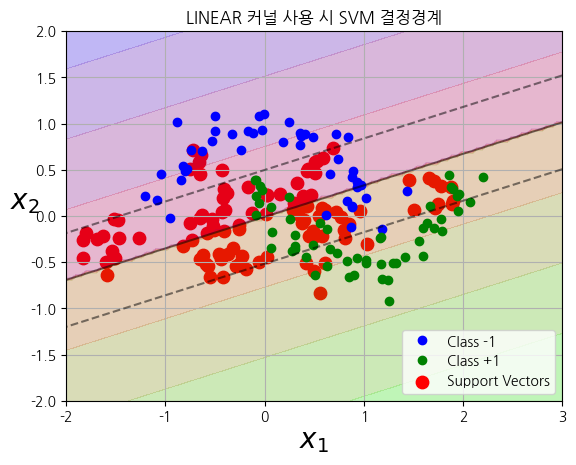

In [31]:
# 선형 커널
"""
Linear Kernel은 선형 데이터셋에 적합한데, Moon Dataset은 비선형 데이터라서
정확도가 다른 커널에 비해 상대적으로 낮게 나옴
그래도 Recall(실제 참인 것 중에서, True로 예측한 것의 비율 -> TP / (TP + FN))값이 90.9점대라 어느정도 분류를 잘 한다는것을 알 수 있음
또한, Precision(참으로 예측한 것 중에서 진짜 참인것의 비율 -> TP / (TP + FP))값은 82점으로, 어느정도 오분류한 결과가 있다는것을 볼 수 있음

탐색 시 n_iter는 10, 100, 1000으로 설정했는데 100과 1000은 결과가 비슷하게 나오는데 시간만 더 걸려서 100으로 설정하였음
처음 Parameter 탐색할 때 svc__C를 0.1 ~ 100까지 범위로 잡았는데, 최적의 C값이 37.55로 나와서, 35 ~ 40으로 범위를 조정하였음
다음 시도 시 최적 하이퍼파라미터 값은  36.87로 나왔으며, 범위를 36 ~ 38로 조정하였음

계속해서 최적 svc__C를 찾아보려고 했으나, recall, precision값이 차이가 없기 때문에 더이상 진행하지 않았음
따라서 최적의 하이퍼파라미터는 svc__C : 36.87임을 알 수 있음
"""

# Try 1
# soft_margin_svm(
#     kernel='linear',
#     parameters={
#         'svc__C': uniform(0.1, 100) # C : Soft Margin SVM의 하이퍼파라미터로, 결정 경계와 서포트 벡터 사이의 마진을 조절하는 역할하는 하이퍼파라미터
#     },
#     n_iter=100
# )

# Try 2
# soft_margin_svm(
#     kernel='linear',
#     parameters={
#         'svc__C': uniform(35, 5)
#     },
#     n_iter=100
# )

# Try 3
# soft_margin_svm(
#     kernel='linear',
#     parameters={
#         'svc__C': uniform(36, 2)
#     },
#     n_iter=100
# )

soft_margin_svm(
    kernel='linear',
    parameters={
        'svc__C': [36.87]
    },
    n_iter=1
)


POLY Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__gamma': 1.3636499344142012, 'svc__degree': 3, 'svc__coef0': 71.06169555339137, 'svc__C': 6.664885281600844}
Confusion Matrix:
 [[55  0]
 [ 1 44]]
Recall    : 1.000
Precision : 0.982


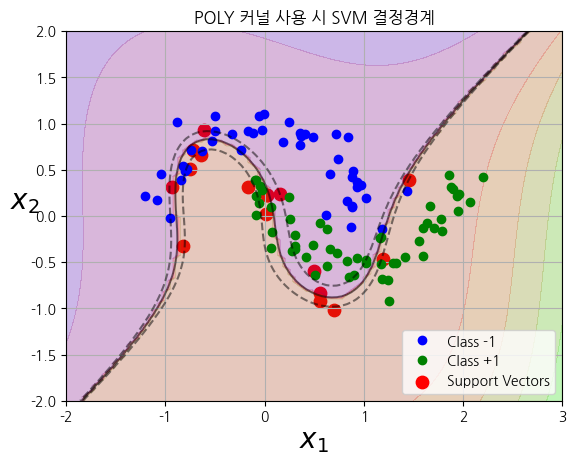

In [30]:
# Polynomial 커널
"""
다항식 커널의 경우, degree, coef0, gamma 파라미터를 전달해야 함
이때, degree는 다항식의 차수, coef0는 다항식 커널에서의 상수항, gamma는 다항식 커널에서의 gamma 값(커널의 폭을 조절하는 하이퍼파라미터)
검색해서 찾아본 결과, degree가 너무 크다면 과적합이 발생할 수 있다고 하므로, 적당히 2 ~ 6으로 설정하였음
coef0는 0 ~ 10 사이로 설정하였고,
gamma는 0.001 ~ 10으로 설정하였음
n_iter값은 MAC Mini M4 기본형 CPU로만 계산해야 하기 때문에 10으로 설정하였음 (100으로 설정 시 너무 오래걸리며, 하드웨어 부하가 커짐)

처음 학습을 진행한 결과, 최적의 하이퍼파라미터는 svc__C : 5.74, svc__coef0 : 72.21, svc__degree : 3, svc__gamma : 2.12로 나왔음
이후 svc__C를 5 ~ 7으로 범위를 조정하였고, svc__coef0는 70 ~ 75로 범위를 조정, svc__degree는 3으로 고정, svc__gamma는 1 ~ 3으로 범위를 조정하였음 -> 이 때, 범위가 조정되어 빠르게 결과가 나왔으므로 n_iter를 100으로 설정하였음

두번째 학습을 진행한 결과, svc__C : 6.66, svc__coef0 : 71.06, svc__degree : 3, svc__gamma : 1.36로 나왔고,
학습 지표는 아래와 같이 나타났음
Confusion Matrix:
 [[55  0]
 [ 1 44]]
Recall    : 1.000
Precision : 0.982
이후 svc__C를 6 ~ 7로 범위를 조정하였고, svc__coef0는 71 ~ 72로 범위를 조정, svc__degree는 3으로 고정, svc__gamma는 1 ~ 1.5로 범위를 조정하였음

세번째 학습을 진행한 결과, svc__C : 6.87, svc__coef0 : 71.01, svc__degree : 3, svc__gamma : 1.36로 나왔음
학습 지표는 아래와 같이 두번째 학습보다 결과가 더 좋지 않음. 따라서 최종 하이퍼파라미터는 두번째 학습 결과로 설정하였음
 [[55  0]
 [ 3 42]]
Recall    : 1.000
Precision : 0.948

따라서 최적의 하이퍼파라미터는 svc_degree : 3, svc__C : 6.664885281600844, svc__coef0 : 71.06169555339137, svc__gamma : 1.3636499344142012임을 알 수 있다.
"""
# Try 1
# soft_margin_svm(
#     kernel='poly',
#     parameters={
#         'svc__degree': randint(2, 6),
#         'svc__C': uniform(0.1, 100),
#         'svc__coef0': uniform(0.01, 100),
#         'svc__gamma': uniform(0.001, 10)
#     },
#     n_iter=10
# )

# Try 2
# soft_margin_svm(
#     kernel='poly',
#     parameters={
#         'svc__degree': [3],
#         'svc__C': uniform(5, 2),
#         'svc__coef0': uniform(70, 5),
#         'svc__gamma': uniform(1, 2)
#     },
#     n_iter=100
# )

# Try 3
# soft_margin_svm(
#     kernel='poly',
#     parameters={
#         'svc__degree': [3],
#         'svc__C': uniform(6, 1),
#         'svc__coef0': uniform(71, 1),
#         'svc__gamma': uniform(1, 0.5)
#     },
#     n_iter=100
# )

soft_margin_svm(
    kernel='poly',
    parameters={
        'svc__degree': [3],
        'svc__C': [6.664885281600844],
        'svc__coef0': [71.06169555339137],
        'svc__gamma': [1.3636499344142012]
    },
    n_iter=1
)


RBF Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__gamma': 10.0, 'svc__C': 1.7}
Confusion Matrix:
 [[55  0]
 [ 2 43]]
Recall    : 1.000
Precision : 0.965


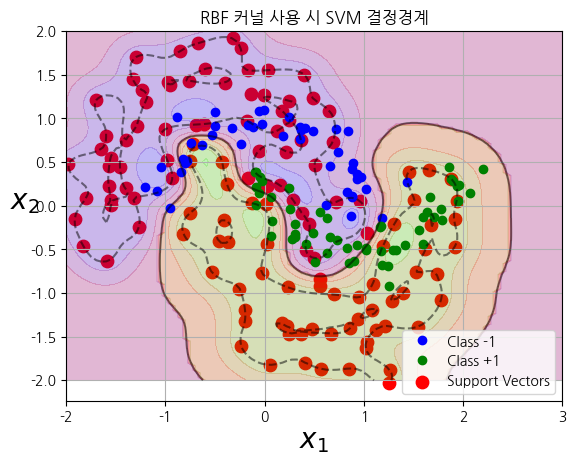

In [27]:
# 가우시안 RBF 커널

"""
RBF Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__C': np.float64(2.0594494295802446), 'svc__gamma': np.float64(9.699198521619943)}
Confusion Matrix:
 [[55  0]
 [ 2 43]]
Recall    : 1.000
Precision : 0.965

RBF Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__C': np.float64(1.749080237694725), 'svc__gamma': np.float64(9.950714306409916)}
Confusion Matrix:
 [[55  0]
 [ 2 43]]
Recall    : 1.000
Precision : 0.965

RBF Kernel을 사용했을 때 최적 하이퍼파라미터: {'svc__C': np.float64(1.6872700594236814), 'svc__gamma': np.float64(10.450714306409916)}
Confusion Matrix:
 [[55  0]
 [ 2 43]]
Recall    : 1.000
Precision : 0.965

계속 범위를 좁혀도 결과는 동일하게 나왔기 때문에, 적절한 하이퍼 파라미터는 svc__C : 1.7, svc__gamma : 10.0라고 추론할 수 있다
"""
# soft_margin_svm(
#     kernel='rbf',
#     parameters={
#         "svc__C": uniform(0.001, 100), # 0.01 ~ 100까지 탐색 -> 1.75가 최적의 결과로 나타나서 1 ~ 3으로 범위 조정
#         "svc__gamma": uniform(0.0001, 10) # 0.0001 ~ 10까지 탐색 -> 9.55 정도가 최적의 감마값으로 나타나서 1 ~ 10으로 범위 조정
#     },
#     n_iter=1000
# )

# soft_margin_svm(
#     kernel='rbf',
#     parameters={
#         "svc__C": uniform(1, 2),
#         "svc__gamma": uniform(9, 1)
#     },
#     n_iter=100
# )

# soft_margin_svm(
#     kernel='rbf',
#     parameters={
#         "svc__C": uniform(1.5, 0.5),
#         "svc__gamma": uniform(9.5, 1)
#     },
#     n_iter=100
# )

soft_margin_svm(
    kernel='rbf',
    parameters={
        "svc__C": [1.7],
        "svc__gamma": [10.0]
    },
    n_iter=1
)